In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Predictions of bus stop related events

<a target="_blank" href="https://colab.sandbox.google.com/github/gena/next25-weather/blob/main/notebooks/weathernext-bigquery-forecast-bus.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Adapted from https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/notebooks/part_3_time_series_forecasting.ipynb

# Overview

This notebook is a continuation of the demo of BigQuery capabilities in a fictional project called **CleanSight**. We'll explore how advanced time-series predictions can be combined with data produced using multimodal analysis.

This notebook will highlight:

* Forecasting expected number of riders for a particular bus stop based on the BigQuery's multiple time-series with univariate and multivariate models.
* Using WeatherNext Graph BigQuery dataset for creating time-series models and for forecasting based on the predicted weather.

Let's get started!

# Prerequisites

The sample code below assumes you have access to a [WeatherNext](https://deepmind.google/technologies/weathernext/#access-weathernext) BigQuery dataset.

We will be using the WeatherNet Graph dataset. For more details on how to get access and the terms and conditions of using this data refer to [the dataset specific documentation](https://console.cloud.google.com/bigquery/analytics-hub/discovery/projects/gcp-public-data-weathernext/locations/us/dataExchanges/weathernext_19397e1bcb7/listings/weathernext_graph_forecasts_19398be87ec). Note: you would need to open this link in a new tab if you get an error related to a missing project.

If you don't have access to the WeatherNext data you can forecast rideship using the univariate model.

## WeatherNext Graph dataset

Once you get access, a linked dataset named `weathernext_graph_forecasts` will be created in your Google Cloud project.

The dataset will contain a table with a numeric name. This table gets updated 4 times a day with newly forecasted data. The data is forecast for a particular rectangular geographic area. The forecast is done in 6 hour intervals and a number of data points are included: expected temperatures at different levels above ground, wind, humidity, etc.

## Getting started

Let's first create some environment variables, including your Google Cloud project ID and the region to deploy resources into.

This notebook assumes that the WeatherNext dataset was created in the same project. If you would like to use a different project, some of the SQL statements will need to be modified to include the project ID of the project which hosts the WeatherNext dataset.

In [3]:
from google.colab import auth
auth.authenticate_user()

In [1]:
PROJECT_ID = "dgena-ee-training" # @param {type:"string"}
REGION = "us-central1" # @param {type:"string"}

### Enable necessary APIs

In [4]:
!gcloud services enable --project {PROJECT_ID} \
  aiplatform.googleapis.com

### Install packages

In [5]:
%pip install --upgrade --user --quiet \
    google-cloud-aiplatform \
    google-cloud-bigquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.9/247.9 kB 16.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Create visualization helper functions


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def display_columns_as_rows(data):
  display_data = data.transpose()
  styler = display_data.style
  styler.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: right;'},
    {'selector': 'th.row_heading', 'props': 'text-align: right;'},
    {'selector': 'td', 'props': 'text-align: right;'},
    ], overwrite=False)
  display(styler)

def plot_historical_and_forecast(title,
                                 historical_data,
                                 timestamp_col_name,
                                 data_col_name,
                                 temperature_col_name=None,
                                 percipitation_col_name=None,
                                 forecast_output=None,
                                 forecast_temperature=None,
                                 actual=None):

    historical_data = historical_data.sort_values(timestamp_col_name)

    display_weather_graphs = temperature_col_name is not None

    figure = plt.figure(figsize=(20, 14 if display_weather_graphs else 6))
    # plt.xlabel('Date and time')

    if display_weather_graphs:
      plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

      temperature_axis = plt.subplot(312)
      plt.ylabel('Temperature (K)')
      plt.plot(historical_data[timestamp_col_name], historical_data[temperature_col_name], color='orange', label='Temperature')
      plt.legend(loc = 'upper center', prop={'size': 14})
      temperature_axis.tick_params(bottom = False, labelbottom = False)

      percipitation_axis = plt.subplot(313, sharex = temperature_axis)
      plt.ylabel('Percipitation (mm)')
      plt.plot(historical_data[timestamp_col_name], historical_data[percipitation_col_name], color='green', label = 'Precipitation')
      plt.legend(loc = 'upper center', prop={'size': 14})

      main_axis = plt.subplot(311, sharex = temperature_axis)
      main_axis.tick_params(bottom = False, labelbottom = False)

    # Plot the input historical data
    plt.ylabel('Number of riders')
    plt.plot(historical_data[timestamp_col_name], historical_data[data_col_name], label = 'Historical')


    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['prediction_interval_lower_bound']
        upper_CI = forecast_output['prediction_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4,
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')

    # Display title, legend
    plt.title(f'{title}', fontsize=20)
    plt.legend(loc = 'upper center', prop={'size': 14})

### Prepare the weather data to be used during the model creation

Let's create a BigQuery dataset which will contain several views to simplify access to the linked WeatherNext dataset.

In [25]:
%%bigquery --project {PROJECT_ID}

DECLARE latest_init_time TIMESTAMP;

-- Find out the latest partition and the name of the table which contains the forecast.
DECLARE weather_metadata DEFAULT (SELECT
  STRUCT(table_name, STRUCT (partition_id AS id, SUBSTRING(partition_id, 0, 4) AS year,
    SUBSTRING(partition_id, 5, 2) AS month,
    SUBSTRING(partition_id, 7, 2) AS day) AS part)  FROM
  `weathernext_graph_forecasts.INFORMATION_SCHEMA.PARTITIONS` WHERE partition_id != '__NULL__' ORDER BY partition_id DESC LIMIT 1);

CREATE SCHEMA IF NOT EXISTS weathernext_graph_derived OPTIONS (description = 'WeatherNext Forecasts - Derived', location = "US");

EXECUTE IMMEDIATE FORMAT("CREATE VIEW IF NOT EXISTS `weathernext_graph_derived.forecast` AS SELECT * FROM `weathernext_graph_forecasts.%s`",
  weather_metadata.table_name);

EXECUTE IMMEDIATE FORMAT("""
    SELECT MAX(init_time)
      FROM `weathernext_graph_derived.forecast` WHERE init_time >= TIMESTAMP('%s-%s-%s 00:00:00')
  """, weather_metadata.part.year, weather_metadata.part.month, weather_metadata.part.day)
  INTO latest_init_time;

EXECUTE IMMEDIATE FORMAT("""
CREATE OR REPLACE VIEW `weathernext_graph_derived.latest_forecast` AS SELECT * FROM `weathernext_graph_derived.forecast` WHERE init_time = TIMESTAMP('%s')
""", STRING(latest_init_time));


Query is running:   0%|          |

""


We now have a dataset named `weathernext_graph_derived`. This dataset has two views:
* `forecast`, which is just an alias to the forecast table in the linked dataset
* `latest_forecast`, which is selects the latest forecast

Consider using the `latest_forecast` view to explore the contents of the dataset because it implements partition pruning of the source table for the cost effective to access partitioned tables.

You can rerun this cell as many times as you need to update the `latest_forecast` view.

Here's the definition of the latest_forecast_view:

In [26]:
!bq show --format=prettyjson '{PROJECT_ID}:weathernext_graph_derived.latest_forecast'

{
  "creationTime": "1741560080997",
  "etag": "GJU9/hwwpQNo4gF7KDbdkw==",
  "id": "dgena-ee-training:weathernext_graph_derived.latest_forecast",
  "kind": "bigquery#table",
  "lastModifiedTime": "1741560080997",
  "location": "US",
  "numActiveLogicalBytes": "0",
  "numBytes": "0",
  "numLongTermBytes": "0",
  "numLongTermLogicalBytes": "0",
  "numRows": "0",
  "numTotalLogicalBytes": "0",
  "schema": {
    "fields": [
      {
        "name": "init_time",
        "type": "TIMESTAMP"
      },
      {
        "name": "geography",
        "type": "GEOGRAPHY"
      },
      {
        "name": "geography_polygon",
        "type": "GEOGRAPHY"
      },
      {
        "fields": [
          {
            "name": "time",
            "type": "TIMESTAMP"
          },
          {
            "name": "hours",
            "type": "INTEGER"
          },
          {
            "name": "total_precipitation_6hr",
            "type": "FLOAT"
          },
          {
            "name": "10m_u_component_

Now, we will extract the historic forecasts for the time period for which we plan to train the model. We are going to use several weather data points, temperature and precipitation, to do the forecasting.

In [27]:
%%bigquery --project {PROJECT_ID}

-- We pick a short period, 1 month, to show how to train the model. A much larger time period
-- can be used in production.
DECLARE historic_data_start_time DEFAULT TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 31 DAY);
DECLARE historic_data_end_time DEFAULT CURRENT_TIMESTAMP;

-- We use zip codes to identify the area we would like to forecast, but you can define
-- the area to cover in a number of different ways.
DECLARE zipcodes_to_cover DEFAULT ["10001", "10002"];
DECLARE geo_area_to_cover DEFAULT (
    WITH zip_areas AS (
      SELECT zip_code_geom as area
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE zip_code in UNNEST(zipcodes_to_cover))
    SELECT ST_UNION(ARRAY_AGG(area)) as combined_area FROM zip_areas);

-- Drop the existing table in case we need to re-create the forecast
DROP TABLE IF EXISTS weathernext_graph_derived.historical_local_forecast;

CREATE TABLE weathernext_graph_derived.historical_local_forecast AS (
WITH
all_forecast_points AS (
  SELECT
      geography,
      geography_polygon,
      forecast_point.time as time,
      -- The model sometimes produces very small negative precipitation numbers; here we normalize the data
      GREATEST(forecast_point.total_precipitation_6hr, 0.) as total_precipitation_6hr,
      forecast_point.`2m_temperature` as `2m_temperature`,
      -- Order the forecast points for same area in reverse chronological order of the forecast to pick the latest
      ROW_NUMBER() OVER (
        PARTITION BY ST_ASBINARY(geography),forecast_point.time
        ORDER BY init_time DESC) as row_number,
      ST_ASBINARY(geography) as location_id,
      FROM weathernext_graph_derived.forecast, UNNEST(forecast.forecast) as forecast_point
  WHERE
    -- Select enough data to cover the required time period
    forecast.init_time BETWEEN TIMESTAMP_SUB(historic_data_start_time, INTERVAL 12 HOUR) AND historic_data_end_time AND
    forecast_point.time BETWEEN TIMESTAMP_SUB(historic_data_start_time, INTERVAL 6 HOUR) AND historic_data_end_time AND
    -- Select all the forecasts that can be relevant
    ST_INTERSECTS(geo_area_to_cover, forecast.geography_polygon)
)
SELECT
    geography,
    geography_polygon,
    STRUCT(
        time,
        total_precipitation_6hr,
        `2m_temperature`,
        -- We also get the previous forecast for this location in order to make subsequent SQLs simpler
        LAG(`2m_temperature`) OVER(PARTITION BY location_id ORDER BY time) as prev_2m_temperature
    ) as forecast
  FROM all_forecast_points
  WHERE row_number = 1
);


Query is running:   0%|          |

""


We now have the dataset of pretty accurate weather forecasts for a given area, spaced by 6 hours:

In [28]:
%%bigquery historical_forecast --project {PROJECT_ID}

SELECT geography, forecast.time, forecast.total_precipitation_6hr, forecast.`2m_temperature`, forecast.`prev_2m_temperature`
  FROM weathernext_graph_derived.historical_local_forecast
  WHERE forecast.prev_2m_temperature IS NOT NULL
  ORDER BY ST_ASBINARY(geography), forecast.time LIMIT 20


Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
display(historical_forecast)

,geography,time,total_precipitation_6hr,2m_temperature,prev_2m_temperature
0,POINT(-74 40.75),2025-02-07 00:00:00+00:00,0.000302,275.193756,275.920197
1,POINT(-74 40.75),2025-02-07 06:00:00+00:00,0.000123,275.625031,275.193756
2,POINT(-74 40.75),2025-02-07 12:00:00+00:00,0.000230,276.623230,275.625031
3,POINT(-74 40.75),2025-02-07 18:00:00+00:00,0.000000,276.589905,276.623230
4,POINT(-74 40.75),2025-02-08 00:00:00+00:00,0.000000,271.611023,276.589905
5,POINT(-74 40.75),2025-02-08 06:00:00+00:00,0.000000,269.233521,271.611023
6,POINT(-74 40.75),2025-02-08 12:00:00+00:00,0.000000,269.206818,269.233521
7,POINT(-74 40.75),2025-02-08 18:00:00+00:00,0.000000,273.728241,269.206818
8,POINT(-74 40.75),2025-02-09 00:00:00+00:00,0.000257,272.943604,273.728241
9,POINT(-74 40.75),2025-02-09 06:00:00+00:00,0.011608,272.917389,272.943604


### Move extracted weather data to the location of bus stop data

If your bus stop data resides in the "US" BigQuery location then there is no need to do anything because the weather and the bus stop data are co-located and can be joined in the same query. Otherwise you will need to copy the extracted weather data. You can do that by using [cross-regional table copy](https://cloud.google.com/bigquery/docs/managing-tables#copy_tables_across_regions) capabilities of BigQuery.

In [30]:
%%bigquery --project {PROJECT_ID} --location {REGION}

CREATE SCHEMA IF NOT EXISTS multimodal;

DROP TABLE IF EXISTS multimodal.historical_local_forecast;

Query is running:   0%|          |

""


In [33]:
!bq cp -sync=false --project_id={PROJECT_ID} -f -n '{PROJECT_ID}:weathernext_graph_derived.historical_local_forecast' '{PROJECT_ID}:multimodal.historical_local_forecast'

**** NOTE! ****  
Successfully started cp dgena-ee-training:bqjob_r295b8567411190fc_000001957d143808_1


# Generate ridership data

Let's assume that bus ridership depends on a number of factors - time of day, day of week, temperature and precipitation. We will generate a synthetic data set of bus ridership for several bus stops.

### Create ridership table

In [42]:
%%bigquery --project {PROJECT_ID} --location {REGION}

DROP TABLE IF EXISTS `multimodal.ridership`;

CREATE TABLE `multimodal.ridership`
  (bus_stop_id STRING, event_ts TIMESTAMP, temperature FLOAT64, total_precipitation_6hr FLOAT64, num_riders INT64)
  CLUSTER BY bus_stop_id;

Query is running:   0%|          |

""


### Generate ridership events


We will generate synthetic ridership events based on a simple approach - generate an array of timestamps in the past, use an array with a couple of bus stops with some metadata (location, typical number of passengers, times of day and week these bus stops are typically busy, etc.). We will use real weather prediction data based on the time stop location and the time point to determine the likely temperature and precipitation. A temporary function will take all the metadata and the weather data and generate the number of riders.

Let's define a SQL function which approximates the temperature at a particular point in time. This function uses linear approximation between two forecasted temperatures 6 hours apart. This is not a perfect approximation formula for temperatures and can be replaced with more sophisticated one if needed.

We will use this function for generation of the synthetic data and for actual forecasting:

In [43]:
%%bigquery --project {PROJECT_ID} --location {REGION}

-- Approximate temperature. That assumes the previous temperature was forecast 6 hours ago.
CREATE OR REPLACE FUNCTION multimodal.temperature_approx(
  forecast STRUCT<
      time TIMESTAMP,
      total_precipitation_6h FLOAT64,
      `2m_temperature` FLOAT64,
      prev_2m_temperature FLOAT64 >, event_ts TIMESTAMP) AS (
    IF(forecast.prev_2m_temperature IS NULL,
      forecast.`2m_temperature`, -- There is no previous temperature; use the current one
      forecast.prev_2m_temperature +
        (forecast.`2m_temperature` - forecast.prev_2m_temperature) -- temperature span, potentially negative
        * (TIMESTAMP_DIFF(event_ts, TIMESTAMP_SUB(forecast.time, INTERVAL 6 HOUR), MINUTE)) -- number of minutes between the previous period and the time point
        / (6 * 60) -- number of minutes in 6 hours
    )
  );

Query is running:   0%|          |

""


We also will create a table with a couple of fictitious bus stops - their ids, locations, and some meta data.

In [44]:
%%bigquery --project {PROJECT_ID} --location {REGION}

-- Two bus stops in New York, NY, USA
DECLARE bus_stop_location_1 DEFAULT ST_GEOGPOINT(-73.98886258282087, 40.745073789633736);
DECLARE bus_stop_location_2 DEFAULT ST_GEOGPOINT( -73.9899701866148, 40.714129256307956);

CREATE OR REPLACE TABLE multimodal.bus_stops AS (
SELECT bus_stop_id, location, base_number_of_riders, busy_in_morning, busy_in_evening, busy_on_weekend FROM UNNEST([
    STRUCT("bus-stop-1" as bus_stop_id, bus_stop_location_1 as location, 5 as base_number_of_riders, false AS busy_in_morning, true AS busy_in_evening, true AS busy_on_weekend),
    STRUCT("bus-stop-2" as bus_stop_id, bus_stop_location_2 as location, 10 as base_number_of_riders, true AS busy_in_morning, false AS busy_in_evening, false AS busy_on_weekend)])
);


Query is running:   0%|          |

""


Now, let's generate the ridership data:

In [45]:
%%bigquery --project {PROJECT_ID} --location {REGION}

DECLARE time_zone DEFAULT "America/New_York";

DECLARE end_ts DEFAULT CURRENT_TIMESTAMP();
-- One month worth of data
DECLARE start_ts DEFAULT TIMESTAMP_SUB(end_ts, INTERVAL 31 DAY);


-- This function generates the number of riders for a given time point
-- It uses several different factors and adds some variance.
CREATE TEMP FUNCTION generate_number_of_riders(
  base_number_of_riders INT64,
  busy_in_morning BOOL,
  busy_in_evening BOOL,
  busy_on_weekend BOOL,
  temperature FLOAT64,
  precipitation FLOAT64,
  event_ts TIMESTAMP)
AS (
  CAST(
    base_number_of_riders
    *
    -- Multiplier based on the temperature (in Kelvin)
    CASE
      -- Less than -3C/26F
      WHEN temperature < 270 THEN .7
      -- More than 32C/90F
      WHEN temperature > 305 THEN .4
      ELSE 1
    END
    *
    -- Multiplier based on precipitation.
    -- The higher the precipitation the fewer the riders
    1/(1 + precipitation)
    *
    -- Multiplier based on the day of week
    CASE
      -- 1 - Sunday
      WHEN EXTRACT(DAYOFWEEK FROM event_ts) BETWEEN 2 AND 6 THEN 2
      ELSE IF(busy_on_weekend, 3, 1)
    END
    *
    -- Multiplier based on the time of the day
    CASE
      -- No riders at night
      WHEN EXTRACT(HOUR FROM event_ts) BETWEEN 0 AND 6
        THEN 0
      -- Morning peak hours
      WHEN EXTRACT(HOUR FROM event_ts) BETWEEN 7 AND 9
        THEN IF(busy_in_morning, 1.5, 1.3)
      -- Evening peak hours
      WHEN EXTRACT(HOUR FROM event_ts) BETWEEN 15 AND 18
        THEN IF(busy_in_evening, 1.5, 1.3)
      -- Otherwise just the base number of riders
      ELSE 1
    END
    -- Add 20% variance
    * (.9 + (RAND()/5))
  AS INT64
  )
);


INSERT INTO multimodal.ridership (bus_stop_id, event_ts, temperature, total_precipitation_6hr, num_riders)
(
WITH
event_timestamps AS (
  SELECT TIMESTAMP(DATETIME(event_ts_in_utc, time_zone)) event_ts FROM
    UNNEST(GENERATE_TIMESTAMP_ARRAY(start_ts, end_ts, INTERVAL 5 MINUTE)) as event_ts_in_utc
),
bus_stops_and_event_timestamps AS (
  -- Cartesian join of the bus stops and time points
  SELECT bus_stops.*, event_ts FROM multimodal.bus_stops, event_timestamps
),
events_and_weather AS (
  SELECT
    bus_stop_id,
    event_ts,
    base_number_of_riders,
    busy_in_morning,
    busy_in_evening,
    busy_on_weekend,
    weather.forecast,
    multimodal.temperature_approx(weather.forecast, event_ts) as temperature,
    FROM bus_stops_and_event_timestamps events, multimodal.historical_local_forecast weather
      WHERE ST_COVERS(weather.geography_polygon, events.location) AND
        event_ts BETWEEN TIMESTAMP_SUB( weather.forecast.time, INTERVAL 6 HOUR) AND weather.forecast.time
)
  SELECT
    bus_stop_id,
    event_ts,
    temperature,
    forecast.total_precipitation_6hr as total_precipitation_6hr,
    generate_number_of_riders(
        base_number_of_riders,
        busy_in_morning,
        busy_in_evening,
        busy_on_weekend,
        temperature,
        forecast.total_precipitation_6hr,
        event_ts) num_riders
    FROM events_and_weather
);

Query is running:   0%|          |

""


### Visualize generated data

Let's take a look at the last 20 days of generated data. The first bus stop graph also shows the temperature and percipitation values.

In [46]:
%%bigquery ridership_history --project {PROJECT_ID} --location {REGION}

SELECT bus_stop_id, event_ts, num_riders, temperature, total_precipitation_6hr
  FROM `multimodal.ridership`
  WHERE event_ts > TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 20 DAY)

Query is running:   0%|          |

Downloading:   0%|          |

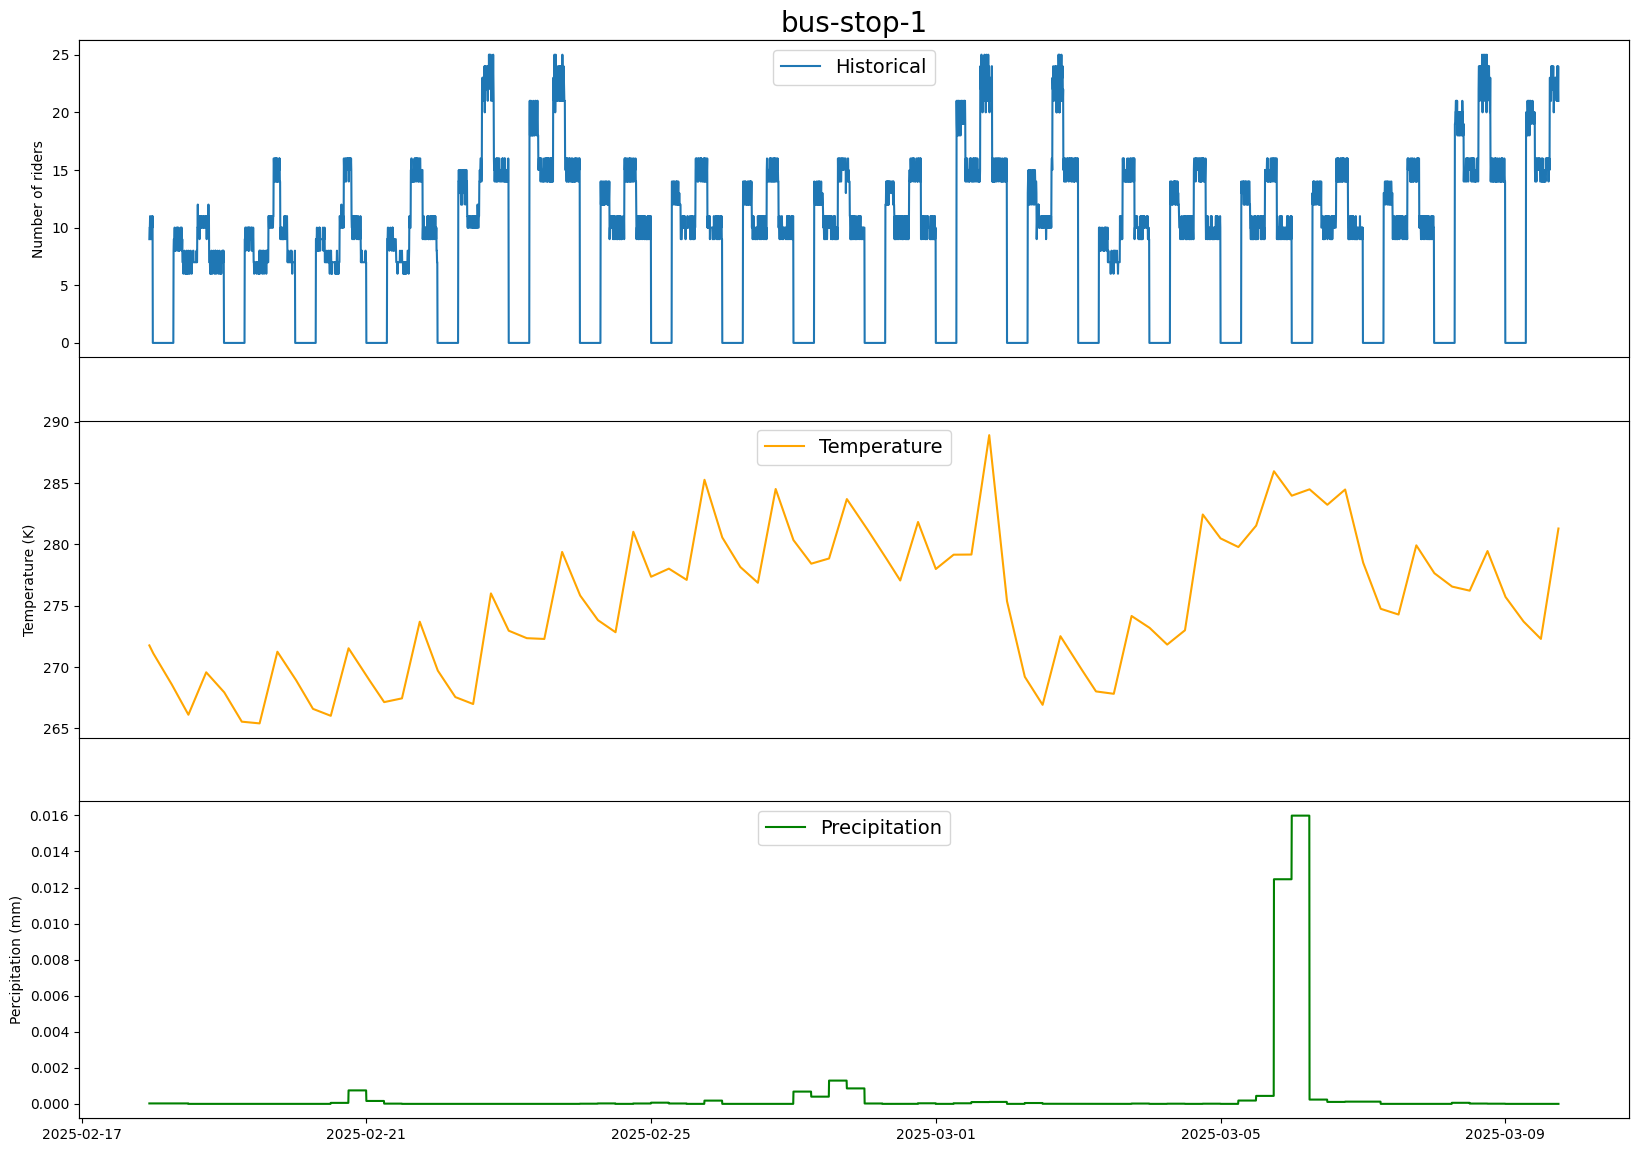

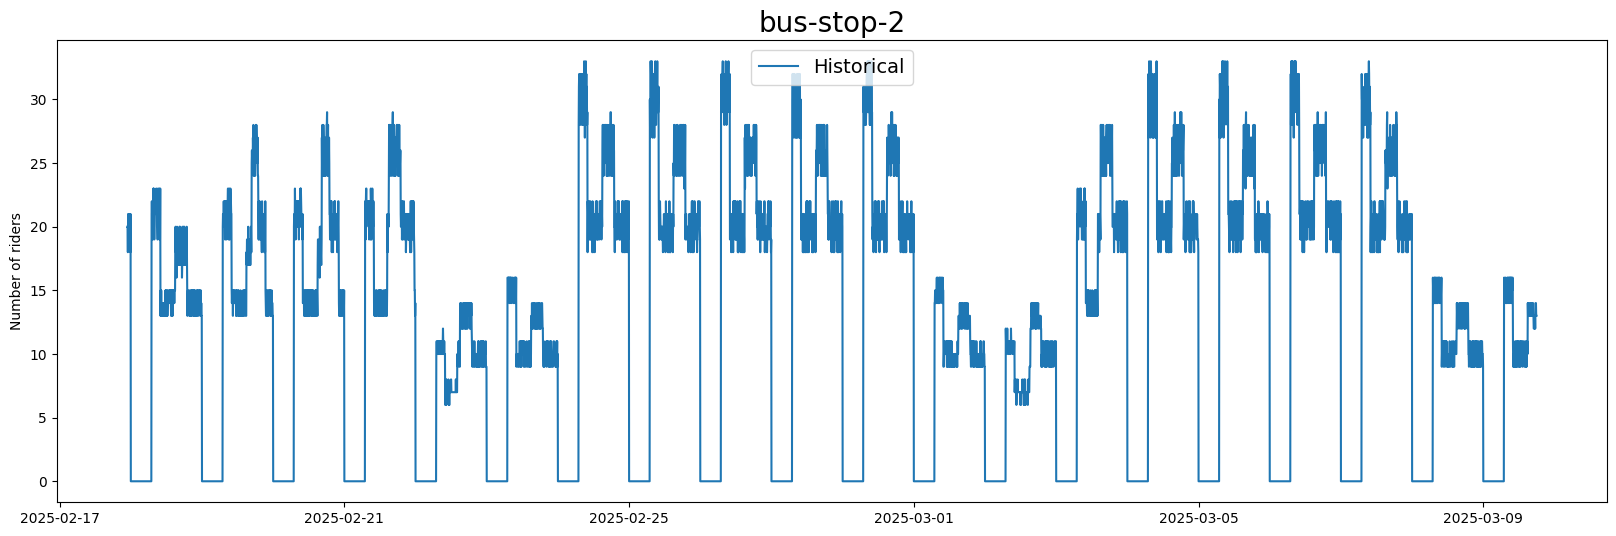

In [47]:
bus_stop_list = list(ridership_history.bus_stop_id.unique())
bus_stop_list.sort()

first_stop = True
for bus_stop_id in bus_stop_list:

    historical_data = ridership_history[ridership_history.bus_stop_id==bus_stop_id]
    plot_historical_and_forecast(historical_data = historical_data,
                                 timestamp_col_name = "event_ts",
                                 data_col_name = "num_riders",
                                 temperature_col_name="temperature" if first_stop else None,
                                 percipitation_col_name="total_precipitation_6hr" if first_stop else None,
                                 title = bus_stop_id)

    first_stop = False

# Forecast bus ridership

Let's see how two built-in BigQuery models, the ARIMA_PLUS and ARIMA_PLUS_XREG, can be used to do time-series forecasting.

## Univariate forecasting using the ARIMA_PLUS model

This model is trained purely on the time point input, hence it is a "univariate" model.



### Train the model

The CREATE MODEL statement used to train the ARIMA_PLUS model has the usual time-series parameters - `time_series_data_col` to identify which data to forecast and `time_series_timestamp_col` to identify the column which contains the time point).

It also has the `time_series_id_col` option. This option identifies the column which will identify a unique time-series within the trained data. In our case, after the training is done there will be two separate models - one for "stop1" and another for "stop2". There can be hundreds of thousands of time-series models created using a single CREATE MODEL statement.

In [48]:
%%bigquery --project {PROJECT_ID} --location {REGION}

CREATE OR REPLACE MODEL `multimodal.ridership_arima_plus`
OPTIONS(
  model_type = 'ARIMA_PLUS',
  time_series_id_col = 'bus_stop_id',
  time_series_data_col = 'num_riders',
  time_series_timestamp_col = 'event_ts'
)
AS SELECT
  bus_stop_id,
  event_ts,
  num_riders
FROM `multimodal.ridership`;

Query is running:   0%|          |

""


### Forecast ridership

Let's forecast using this model. This is done by calling the table-valued-function (TVF) ML.FORECAST with a reference to the model trained in the prevous step. There is no additional data needed to forecast. The second parameter to the function affects how many data points since the last model training period is to produce ("horizon") and the level of confidence in the forecast values. For details, refer to the [ML.FORECAST documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast).

In [49]:
%%bigquery arima_plus_forecast --project {PROJECT_ID} --location {REGION}

SELECT
  *
FROM
  ML.FORECAST (
    model `multimodal.ridership_arima_plus`,
    STRUCT (1000 AS horizon, 0.8 AS confidence_level));

Query is running:   0%|          |

Downloading:   0%|          |

Here's the data returned by the forecast function:

In [50]:
display(arima_plus_forecast)

,bus_stop_id,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,bus-stop-1,2025-03-09 18:00:38.899449+00:00,21.371776,0.470703,0.8,20.768200,21.975353,20.768200,21.975353
1,bus-stop-1,2025-03-09 18:05:38.899449+00:00,23.186905,0.477441,0.8,22.574689,23.799121,22.574689,23.799121
2,bus-stop-1,2025-03-09 18:10:38.899449+00:00,22.067683,0.481586,0.8,21.450151,22.685215,21.450151,22.685215
3,bus-stop-1,2025-03-09 18:15:38.899449+00:00,21.965445,0.487396,0.8,21.340464,22.590427,21.340464,22.590427
4,bus-stop-1,2025-03-09 18:20:38.899449+00:00,23.581602,0.491916,0.8,22.950825,24.212379,22.950825,24.212379
...,...,...,...,...,...,...,...,...,...
1995,bus-stop-2,2025-03-13 04:55:38.899449+00:00,0.192569,3.322132,0.8,-4.067357,4.452495,-4.067357,4.452495
1996,bus-stop-2,2025-03-13 05:00:38.899449+00:00,0.193841,3.323724,0.8,-4.068126,4.455808,-4.068126,4.455808
1997,bus-stop-2,2025-03-13 05:05:38.899449+00:00,0.195113,3.325316,0.8,-4.068894,4.459121,-4.068894,4.459121
1998,bus-stop-2,2025-03-13 05:10:38.899449+00:00,0.196713,3.326906,0.8,-4.069335,4.462760,-4.069335,4.462760


#### Visualize the forecast

Looks like our forecast is pretty accurate based on the previous ridership pattern:

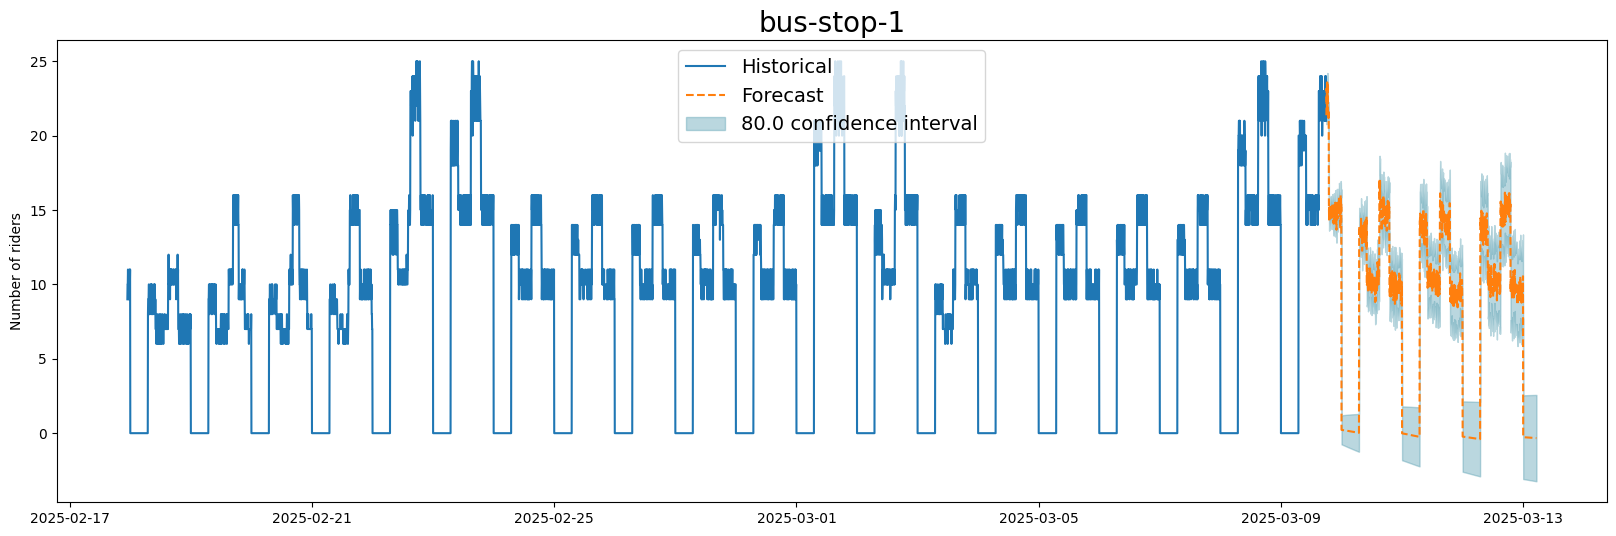

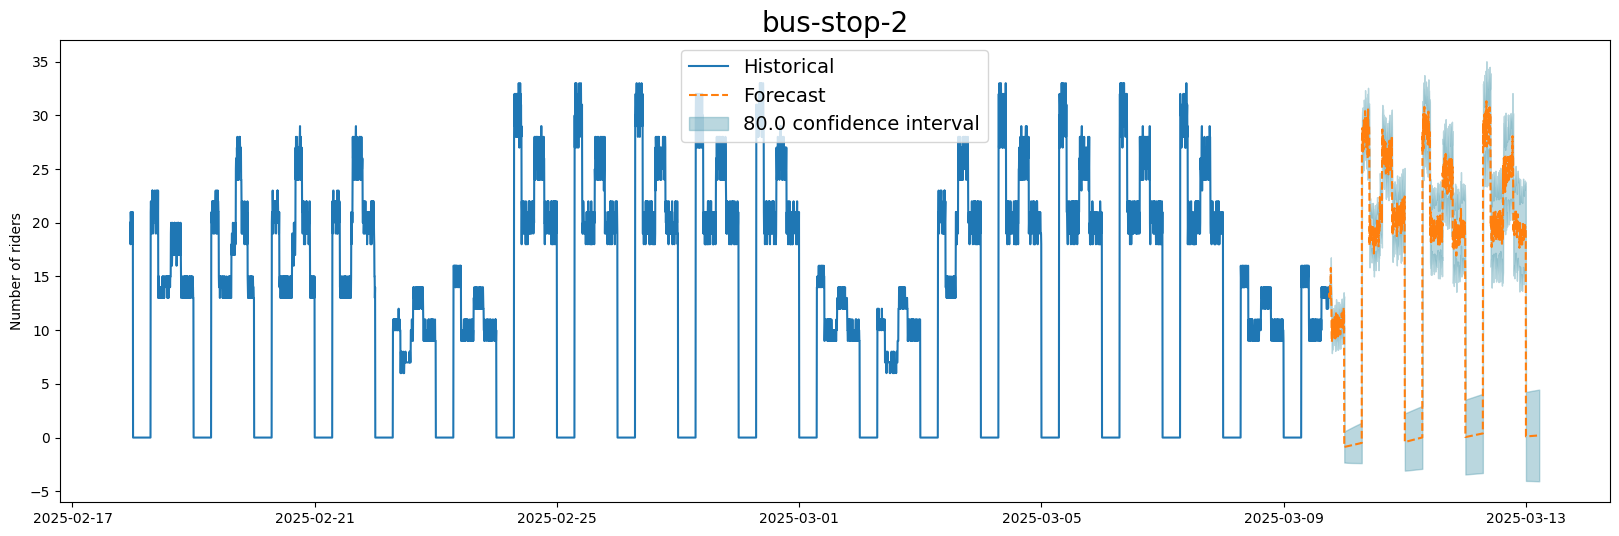

In [51]:
bus_stop_list = list(ridership_history.bus_stop_id.unique())
bus_stop_list.sort()

for bus_stop_id in bus_stop_list:

    historical_data = ridership_history[ridership_history.bus_stop_id==bus_stop_id]
    forecast_data = arima_plus_forecast[arima_plus_forecast.bus_stop_id==bus_stop_id]
    plot_historical_and_forecast(historical_data = historical_data,
                                 timestamp_col_name = "event_ts",
                                 data_col_name = "num_riders",
                                 forecast_output = forecast_data,
                                 title = bus_stop_id)

## Multivariate forecasting using the ARIMA_PLUS_XREG model

The ARIMA_PLUS_XREG model is called a "multivariate" model because in addition to the time points it also uses additional features, provided for each time point, to identify if they affect the time-series. In our case these features are the temperature and precipitation.

### Train the model

The same CREATE MODEL statement is used to train this model Many options, e.g,  `time_series_data_col`, `time_series_timestamp_col`,  `time_series_id_col` have the same meaning as for the ARIMA_PLUS model.

The main difference - the ARIMA_PLUS_XREG model uses all columns besides those identified by the options above as the feature columns and uses linear regression to calculate covariate weights.

For details on the additional options, explanation of the training process, and best practices when training and using the model please refer to BigQuery documentation on [the CREATE MODEL statement for ARIMA_PLUS_XREG models](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series).

In [52]:
%%bigquery --project {PROJECT_ID} --location {REGION}

CREATE OR REPLACE MODEL `multimodal.ridership_arima_plus_xreg`
OPTIONS(
  model_type = 'ARIMA_PLUS_XREG',
  time_series_id_col = 'bus_stop_id',
  time_series_data_col = 'num_riders',
  time_series_timestamp_col = 'event_ts'
)
AS SELECT
  bus_stop_id,
  event_ts,
  num_riders,
  -- Two additional feature that can affect the forecasting
  temperature,
  total_precipitation_6hr
FROM `multimodal.ridership`;

Query is running:   0%|          |

""


### Forecast ridership

Forecasting with the ARIMA_PLUS model was pretty simple. But in case of the XREG model we also need to provide the expected feature columns. We are going to need to get the weather forecast data ready.

#### Get the latest weather forecast


We have already prepared the historical data forecast. Now we are going to get the latest, most accurate, forecast extracted into a separate table.

In [60]:
%%bigquery --project {PROJECT_ID} --location {REGION}

-- We are going to use the same geo area as the one that we used for historical data generation

-- We use zip codes to identify the area we would like to forecast, but you can define
-- the area to cover in a number of different ways.
DECLARE zipcodes_to_cover DEFAULT ["10001", "10002"];
DECLARE geo_area_to_cover DEFAULT (
    WITH zip_areas AS (
      SELECT zip_code_geom as area
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE zip_code in UNNEST(zipcodes_to_cover))
    SELECT ST_UNION(ARRAY_AGG(area)) as combined_area FROM zip_areas);

DROP TABLE IF EXISTS weathernext_graph_derived.latest_local_forecast;

CREATE TABLE weathernext_graph_derived.latest_local_forecast AS (
  SELECT
      geography,
      geography_polygon,
      STRUCT(
        forecast_point.time as time,
        GREATEST(forecast_point.total_precipitation_6hr, 0.) as total_precipitation_6hr,
        forecast_point.`2m_temperature` as `2m_temperature`,
        LAG(`2m_temperature`) OVER(PARTITION BY ST_ASBINARY(geography) ORDER BY time) as prev_2m_temperature) as forecast
  -- "latest_forecast" is a view we generated in a previous step.
  -- A new forecast is created every 6 hours. To update the view to point to the latest forecast - rerun the block.
  FROM weathernext_graph_derived.latest_forecast, UNNEST(latest_forecast.forecast) as forecast_point
  WHERE ST_INTERSECTS(geo_area_to_cover, latest_forecast.geography_polygon)
);


Executing query with job ID: 11411c96-bd07-402d-9250-51be7264afc5
Query executing: 0.17s


ERROR:
 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/dgena-ee-training/queries/11411c96-bd07-402d-9250-51be7264afc5?maxResults=0&location=us-central1&prettyPrint=false: Access Denied: Table bigquery-public-data:geo_us_boundaries.zip_codes: User does not have permission to query table bigquery-public-data:geo_us_boundaries.zip_codes, or perhaps it does not exist. at [6:35]

Location: us-central1
Job ID: 11411c96-bd07-402d-9250-51be7264afc5



Let's see what's in that table:

In [54]:
%%bigquery local_forecast --project {PROJECT_ID} --location {REGION}

SELECT geography, forecast.time, forecast.total_precipitation_6hr, forecast.`2m_temperature`, forecast.`prev_2m_temperature`
  FROM weathernext_graph_derived.latest_local_forecast
  WHERE forecast.prev_2m_temperature IS NOT NULL
  ORDER BY ST_ASBINARY(geography), forecast.time LIMIT 20

Executing query with job ID: e5d9d3a6-11df-41f0-b0f2-783bcb28f792
Query executing: 0.21s


ERROR:
 404 Not found: Dataset dgena-ee-training:weathernext_graph_derived was not found in location us-central1; reason: notFound, message: Not found: Dataset dgena-ee-training:weathernext_graph_derived was not found in location us-central1

Location: us-central1
Job ID: e5d9d3a6-11df-41f0-b0f2-783bcb28f792



In [57]:
display(local_forecast)

QueryJob<project=dgena-ee-training, location=us-central1, id=e5d9d3a6-11df-41f0-b0f2-783bcb28f792>

Let's move the latest forecast data to the location of the model:

In [56]:
%%bigquery --project {PROJECT_ID} --location {REGION}

DROP TABLE IF EXISTS multimodal.latest_local_forecast;

Query is running:   0%|          |

""


In [59]:
! bq cp -f --project_id {PROJECT_ID} -sync=false -n '{PROJECT_ID}:weathernext_graph_derived.latest_local_forecast' '{PROJECT_ID}:multimodal.latest_local_forecast'

**** NOTE! ****  
BigQuery error in cp operation: Not found: Table dgena-ee-
training:weathernext_graph_derived.latest_local_forecast


#### Run the time-series forecast

If we were to use the ARIMA_PLUS model we could have just run the ML.FORECAST function to get time-series predictions. But the ARIMA_PLUS_XREG assumes that additional features will affect the forecast and you must provide the expected features to the ML.FORECAST function.

We already have most of the parts to prepare the features. Let's first test the feature preparation SQL before running the model.



In [ ]:
%%bigquery expected_features --project {PROJECT_ID}

DECLARE time_zone DEFAULT "America/New_York";

-- Forecast from now...
DECLARE start_ts DEFAULT CURRENT_TIMESTAMP();
-- to 5 days forward
DECLARE end_ts DEFAULT TIMESTAMP_ADD(start_ts, INTERVAL 5 DAY);

WITH
event_timestamps AS (
  SELECT TIMESTAMP(DATETIME(event_ts_in_utc, time_zone)) event_ts FROM
    UNNEST(GENERATE_TIMESTAMP_ARRAY(start_ts, end_ts, INTERVAL 5 MINUTE)) as event_ts_in_utc
),
bus_stops_and_event_timestamps AS (
  -- Cartesian join of the bus stops and time points
  -- We only need the bus stop ids and locations, not all the meta data
  SELECT bus_stops.bus_stop_id, bus_stops.location, event_ts
    FROM multimodal.bus_stops, event_timestamps
),
events_and_weather AS (
  SELECT
    bus_stop_id,
    event_ts,
    weather.forecast,
    multimodal.temperature_approx(weather.forecast, event_ts) as temperature,
    -- we are getting the latest forecast data, not historical
    FROM bus_stops_and_event_timestamps events, multimodal.latest_local_forecast weather
      WHERE ST_COVERS(weather.geography_polygon, events.location) AND
        event_ts BETWEEN TIMESTAMP_SUB(weather.forecast.time, INTERVAL 6 HOUR) AND weather.forecast.time
)
SELECT
    bus_stop_id,
    event_ts,
    -- the two features used by the model
    temperature,
    forecast.total_precipitation_6hr as total_precipitation_6hr,
    FROM events_and_weather
    -- we are going to drop these clauses later, this is just to help with visualization
    ORDER by bus_stop_id, event_ts
    LIMIT 50;

Let's see what these features look like:

In [ ]:
display(expected_features)

OK, the features look correct. One nuance - you might see that the temperature values are unchanged for some earlier event timestamps. This is because our latest forecast table doesn't have temperature values for earlier forecasts and the temperature approximation function just takes the current value if there is no earlier one. We can find this data if needed by looking at the previous forecast, but that would result in more complex SQL statement.

Let's run the forecast. We will use most of the feature preparation SQL in the forecasting function. Alternatively, we could have prepared the features and saved them in a table and used the whole table as the feature input to the forecast function.

In [ ]:
%%bigquery ridership_forecast --location {REGION}

DECLARE time_zone DEFAULT "America/New_York";

-- Forecast from now...
DECLARE start_ts DEFAULT CURRENT_TIMESTAMP();
-- to 5 days forward
DECLARE end_ts DEFAULT TIMESTAMP_ADD(start_ts, INTERVAL 5 DAY);

SELECT
  *
FROM
  ML.FORECAST (
    model `multimodal.ridership_arima_plus_xreg`,
    STRUCT (1000 AS horizon, 0.8 AS confidence_level),
    (
WITH
event_timestamps AS (
  SELECT TIMESTAMP(DATETIME(event_ts_in_utc, time_zone)) event_ts FROM
    UNNEST(GENERATE_TIMESTAMP_ARRAY(start_ts, end_ts, INTERVAL 5 MINUTE)) as event_ts_in_utc
),
bus_stops_and_event_timestamps AS (
  -- Cartesian join of the bus stops and time points
  -- We only need the bus stop ids and locations, not all the meta data
  SELECT bus_stops.bus_stop_id, bus_stops.location, event_ts FROM multimodal.bus_stops, event_timestamps
),
events_and_weather AS (
  SELECT
    bus_stop_id,
    event_ts,
    weather.forecast,
    multimodal.temperature_approx(weather.forecast, event_ts) as temperature,
    -- we are getting the latest forecast data, not historical
    FROM bus_stops_and_event_timestamps events, multimodal.latest_local_forecast weather
      WHERE ST_COVERS(weather.geography_polygon, events.location) AND
        event_ts BETWEEN TIMESTAMP_SUB( weather.forecast.time, INTERVAL 6 HOUR) AND weather.forecast.time
)
SELECT
    bus_stop_id,
    event_ts,
    -- the two features used by the model
    temperature,
    forecast.total_precipitation_6hr as total_precipitation_6hr,
    FROM events_and_weather    )
  );

#### Visualize the forecast

Here's what the ML.FORECAST function returns:

In [ ]:
display(ridership_forecast)

Let's visualize the forecast:

In [ ]:

bus_stop_list = list(ridership_history.bus_stop_id.unique())
bus_stop_list.sort()

for bus_stop_id in bus_stop_list:

    historical_data = ridership_history[ridership_history.bus_stop_id==bus_stop_id]
    forecast_data = ridership_forecast[ridership_forecast.bus_stop_id==bus_stop_id]
    plot_historical_and_forecast(historical_data = historical_data,
                                 timestamp_col_name = "event_ts",
                                 data_col_name = "num_riders",
                                 forecast_output = forecast_data,
                                 title = bus_stop_id)

# Selecting the right model

In the previous sections we have seen the mechanics of creating and using two time-series forecasting models. The univariate model is simpler to create and is simpler to use for forecasting. The multivariate model can give more accurate forecasting. In a real production implementation it would be important to capture the prediction results and compare with the actual outcomes. This would help to decide if it's worth building the multivariate model, fine tune other model parameters - training data period, additional features, effect of holidays and seasonality, etc.

Part of the model selection process is model evaluation and forecast evaluation.  

## Model evaluation

In [ ]:
%%bigquery arima_plus_model_evaluation --project {PROJECT_ID}

SELECT
  *
FROM
  ML.ARIMA_EVALUATE(MODEL multimodal.ridership_arima_plus, STRUCT(FALSE AS show_all_candidate_models))

In [ ]:
display_columns_as_rows(arima_plus_model_evaluation)

You can see that there are multiple time series models under the over, one for each bus stop. For details on how to interpret the output of ML.ARIMA_EVALUATE function refer to the [BigQuery documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate).

## Forecast evaluation

To evaluate the forecast, use the same parameters as use for ML.FORECAST function to call ML.EXPLAIN_FORECAST:

In [ ]:
%%bigquery arima_plus_forecast_explanation --project {PROJECT_ID}

SELECT *
 FROM ML.EXPLAIN_FORECAST(
  MODEL multimodal.ridership_arima_plus,
  STRUCT(300 AS horizon, 0.8 AS confidence_level))

The output of the function contains two types of records - the ones that were used for trainging and the actual forecast.

Here are a couple of records of historical records:

In [ ]:
data_to_show = arima_plus_forecast_explanation[
    (arima_plus_forecast_explanation['bus_stop_id'] == 'bus-stop-1') &
    (arima_plus_forecast_explanation['time_series_type'] == 'history')]


display_columns_as_rows(data_to_show.head(2))

And here are some fo the forecast records:

In [ ]:
data_to_show = arima_plus_forecast_explanation[
    (arima_plus_forecast_explanation['bus_stop_id'] == 'bus-stop-1') &
    (arima_plus_forecast_explanation['time_series_type'] == 'forecast')]


display_columns_as_rows(data_to_show.head(2))

For details on how to interpret the output of the function refer to the [BigQuery documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast).

# Conclusion

We showed how you can use two different time-series forecasting models available in BigQuery.

We also showed how the WeatherNext Graph dataset can be used to get historical and future weather forecasts.

There are multiple use cases for these time-series forecasts. For example, an AI agent can use the results of ridership forecast as an input to decision on how to perform a task like this: "In the next week schedule the repair of the bus stop #2 during the least impactful to passengers time".